This notebook is a tutorial for training and prediction in data2.

# start

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from script.MIGNN_model import Graph_DataLoader,MIGNN_model2
from script.SEMG import Calc_SPMS_Elec,Scaler 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

Using backend: pytorch[10:27:42] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /root/anaconda3/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.11.0.so: cannot open shared object file: No such file or directory



# data

In [6]:
data_file = './data2/data2.csv'
mol_dir = './data2/data2_sdf_files/'

In [7]:
tmp_df = pd.read_csv(data_file)
cat_smiles = np.array(tmp_df['Catalyst'].to_list())
imine_smiles = np.array(tmp_df['Imine'].to_list())
thiol_smiles = np.array(tmp_df['Thiol'].to_list())
labels = np.array(tmp_df['Output'].to_list())
label_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))
cat_smi_set = list(set(cat_smiles))
imine_smi_set = list(set(imine_smiles))
thiol_smi_set = list(set(thiol_smiles))

In [8]:
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()

smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [11]:
sort_func = lambda x: eval(x.split('/')[-1].split('.')[0].split('_')[-1])
cat_files = sorted(glob.glob('./data2/data2_sdf_files/cat_*.sdf'),key=sort_func)
imine_files = sorted(glob.glob('./data2/data2_sdf_files/imine_*.sdf'),key=sort_func)
thiol_files = sorted(glob.glob('./data2/data2_sdf_files/thiol_*.sdf'),key=sort_func)

cat_spms,cat_elec_desc,cat_id_name_dict = Calc_SPMS_Elec(cat_files,mol_dir,align='Origin',sphere_radius = 4).calc_spms_elec(cat_files,mol_dir)
imine_spms,imine_elec_desc,imine_id_name_dict = Calc_SPMS_Elec(imine_files,mol_dir,align='Origin',sphere_radius = 4).calc_spms_elec(imine_files,mol_dir)
thiol_spms,thiol_elec_desc,thiol_id_name_dict = Calc_SPMS_Elec(thiol_files,mol_dir,align='Origin',sphere_radius = 4).calc_spms_elec(thiol_files,mol_dir)

cat_spms = Scaler(cat_spms)
imine_spms = Scaler(imine_spms)
thiol_spms = Scaler(thiol_spms)

cat_elec_desc = Scaler(cat_elec_desc)
imine_elec_desc = Scaler(imine_elec_desc)
thiol_elec_desc = Scaler(thiol_elec_desc)

In [14]:
total_cat_spms = np.array([cat_spms[cat_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in cat_smiles])
total_imine_spms = np.array([imine_spms[imine_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in imine_smiles])
total_thiol_spms = np.array([thiol_spms[thiol_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in thiol_smiles])

total_cat_elec_desc = np.array([cat_elec_desc[cat_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in cat_smiles])
total_imine_elec_desc = np.array([imine_elec_desc[imine_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in imine_smiles])
total_thiol_elec_desc = np.array([thiol_elec_desc[thiol_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in thiol_smiles])

cat_spms_trans = np.transpose(total_cat_spms,(0,2,3,1))
imine_spms_trans = np.transpose(total_imine_spms,(0,2,3,1))
thiol_spms_trans = np.transpose(total_thiol_spms,(0,2,3,1))

cat_elec_trans = np.transpose(total_cat_elec_desc,(0,2,3,4,1))
imine_elec_trans = np.transpose(total_imine_elec_desc,(0,2,3,4,1))
thiol_elec_trans = np.transpose(total_thiol_elec_desc,(0,2,3,4,1))

react_spms = np.concatenate([cat_spms_trans,imine_spms_trans,thiol_spms_trans],axis=3)
react_elec = np.concatenate([cat_elec_trans,imine_elec_trans,thiol_elec_trans],axis=4)
label_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

# IGNN model

In [16]:
class IGNN_model2(keras.Model):
    def __init__(self,cat_size,imine_size,thiol_size,hidden_size=256,linear_depth=10,atom_attention=4,
                 inter_attention=1,end_attention=1,inter_len=8,interaction='False',spms_number=32,
                 ele_number=32,fc_size=256,final_act='sigmoid'):

        super(IGNN_model2,self).__init__()
        self.cat_size = cat_size
        self.imine_size = imine_size
        self.thiol_size = thiol_size
        self.hidden_size = hidden_size
        self.linear_depth = linear_depth
        self.atom_attention=atom_attention
        self.inter_attention=inter_attention
        self.end_attention=end_attention
        self.inter_len=inter_len
        self.interaction=interaction
        self.final_act = final_act
        self.spms_number=spms_number
        self.ele_number=ele_number
        
        self.norm_cat = keras.layers.BatchNormalization()
        self.norm_imine = keras.layers.BatchNormalization()
        self.norm_thiol = keras.layers.BatchNormalization()
        self.norm_ar_ha = keras.layers.BatchNormalization()    
        self.cat_spms_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.cat_spms_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.cat_spms_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.cat_spms_attention_dense = Dense(cat_size, activation='softmax', name='attention_vec')
        self.cat_spms_attention_mul =  Multiply()
        self.cat_elec_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.cat_elec_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.cat_elec_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)       
        self.cat_elec_attention_dense = Dense(cat_size, activation='softmax', name='attention_vec')
        self.cat_elec_attention_mul =  Multiply()        
        self.imine_spms_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.imine_spms_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.imine_spms_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.imine_spms_attention_dense = Dense(imine_size, activation='softmax', name='attention_vec')
        self.imine_spms_attention_mul =  Multiply()
        
        self.imine_elec_init_layer = keras.layers.Dense(hidden_size,
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.imine_elec_hidden_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.imine_elec_final_layer = keras.layers.Dense(1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.imine_elec_attention_dense = Dense(imine_size, activation='softmax', name='attention_vec')
        self.imine_elec_attention_mul =  Multiply()  
        self.thiol_spms_init_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.thiol_spms_hidden_layer = keras.layers.Dense(hidden_size,
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.thiol_spms_final_layer = keras.layers.Dense(1,kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.thiol_spms_attention_dense = Dense(thiol_size, activation='softmax', name='attention_vec')
        self.thiol_spms_attention_mul =  Multiply()        
        self.thiol_elec_init_layer = keras.layers.Dense(hidden_size,
                                     kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.thiol_elec_hidden_layer = keras.layers.Dense(hidden_size,
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.thiol_elec_final_layer = keras.layers.Dense(1,kernel_initializer=tf.random_normal_initializer(stddev=0.1),use_bias=False)
        self.thiol_elec_attention_dense = Dense(thiol_size, activation='softmax', name='attention_vec')
        self.thiol_elec_attention_mul =  Multiply()  

        self.super_spms_attention_dense = Dense(self.spms_number, activation='softmax', name='attention_vec')
        self.super_spms_attention_mul =  Multiply() 
        self.super_ele_attention_dense = Dense(self.ele_number, activation='softmax', name='attention_vec')
        self.super_ele_attention_mul =  Multiply() 
        self.conv2d_1 = keras.layers.Conv2D(16,(3,5))
        self.conv2d_2 = keras.layers.Conv2D(16,(2,3))
        self.conv2d_3 = keras.layers.Conv2D(1,(16,16))
        self.conv2d_4 = keras.layers.Conv2D(1,(8,8))
        self.conv2d_5 = keras.layers.Conv2D(1,(inter_len,inter_len))
        self.conv2d_6 = keras.layers.Conv2D(1,(16,16))
        self.conv2d_7 = keras.layers.Conv2D(1,(8,8))
        self.conv2d_8 = keras.layers.Conv2D(1,(inter_len,inter_len))
        self.conv3d = keras.layers.Conv3D(16,4)
        self.fc_1 = keras.layers.Dense(fc_size)
        self.fc_2 = keras.layers.Dense(fc_size)
        self.fc_3 = keras.layers.Dense(1,activation='sigmoid')
        self.fc_4 = keras.layers.Dense(1)
        self.fc_5 = keras.layers.Dense(32)
        self.fc_6 = keras.layers.Dense(32)
        
        self.maxpooling_2d = keras.layers.MaxPool2D(2)
        self.maxpooling_3d = keras.layers.MaxPool3D(2)
        self.flatten = keras.layers.Flatten()        
        self.x_attention_dense = Dense(434, activation='softmax', name='attention_vec')
        self.x_attention_mul =  Multiply()         
    def call(self,input_):
        spms_x = input_[0]
        elec_x = input_[1]
        number_batch=len(spms_x)
        cat_x = spms_x[:,:,:,:self.cat_size]
        imine_x = spms_x[:,:,:,self.cat_size:self.cat_size+self.imine_size]
        thiol_x = spms_x[:,:,:,self.cat_size+self.imine_size:]
        cat_elec_x = elec_x[:,:,:,:,:self.cat_size]
        imine_elec_x = elec_x[:,:,:,:,self.cat_size:self.cat_size+self.imine_size]
        thiol_elec_x = elec_x[:,:,:,:,self.cat_size+self.imine_size:]
        for i in range(self.atom_attention):
            cat_x_=self.cat_spms_attention_dense(cat_x)
            cat_x=self.cat_spms_attention_mul([cat_x,cat_x_])    
            imine_x_=self.imine_spms_attention_dense(imine_x)
            imine_x=self.imine_spms_attention_mul([imine_x,imine_x_])  
            thiol_x_=self.thiol_spms_attention_dense(thiol_x)
            thiol_x=self.thiol_spms_attention_mul([thiol_x,thiol_x_])   
            cat_elec_x_=self.cat_elec_attention_dense(cat_elec_x)
            cat_elec_x=self.cat_elec_attention_mul([cat_elec_x,cat_elec_x_])
            imine_elec_x_=self.imine_elec_attention_dense(imine_elec_x)
            imine_elec_x=self.imine_elec_attention_mul([imine_elec_x,imine_elec_x_])
            thiol_elec_x_=self.thiol_elec_attention_dense(thiol_elec_x)
            thiol_elec_x=self.thiol_elec_attention_mul([thiol_elec_x,thiol_elec_x_])  
        #self.cat_x_=cat_x_
        #self.imine_x_=imine_x_
        #self.thiol_x_=thiol_x_
        #self.thiol_x=thiol_x
        cat_x = self.cat_spms_init_layer(cat_x)
        for i in range(self.linear_depth):
            cat_x = self.cat_spms_hidden_layer(cat_x)
        cat_x = self.cat_spms_final_layer(cat_x)
        cat_x = self.norm_cat(cat_x)
        cat_x = tf.nn.tanh(cat_x)
        imine_x = self.imine_spms_init_layer(imine_x)
        for i in range(self.linear_depth):
            imine_x = self.imine_spms_hidden_layer(imine_x)
        imine_x = self.imine_spms_final_layer(imine_x)
        imine_x = self.norm_imine(imine_x)
        imine_x = tf.nn.tanh(imine_x)
        thiol_x = self.thiol_spms_init_layer(thiol_x)
        for i in range(self.linear_depth):
            thiol_x = self.thiol_spms_hidden_layer(thiol_x)   
        thiol_x = self.thiol_spms_final_layer(thiol_x)
        thiol_x = self.norm_thiol(thiol_x)
        thiol_x = tf.nn.tanh(thiol_x)
        react_spms_mat = tf.concat([cat_x,imine_x,thiol_x],axis=3)
        react_spms_x = self.conv2d_2(self.maxpooling_2d(self.conv2d_1(react_spms_mat)))
        react_spms_x = self.flatten(react_spms_x)    
        cat_elec_x = self.cat_elec_init_layer(cat_elec_x)
        for i in range(self.linear_depth):
            cat_elec_x = self.cat_elec_hidden_layer(cat_elec_x)
        cat_elec_x = self.cat_elec_final_layer(cat_elec_x)
        cat_elec_x = tf.nn.tanh(cat_elec_x)
        imine_elec_x = self.imine_elec_init_layer(imine_elec_x)
        for i in range(self.linear_depth):
            imine_elec_x = self.imine_elec_hidden_layer(imine_elec_x)
        imine_elec_x = self.imine_elec_final_layer(imine_elec_x)
        imine_elec_x = tf.nn.tanh(imine_elec_x)
        thiol_elec_x = self.thiol_elec_init_layer(thiol_elec_x)
        for i in range(self.linear_depth):
            thiol_elec_x = self.thiol_elec_hidden_layer(thiol_elec_x)
        thiol_elec_x = self.thiol_elec_final_layer(thiol_elec_x)
        thiol_elec_x = tf.nn.tanh(thiol_elec_x)
        react_elec_x = tf.concat([cat_elec_x,imine_elec_x,thiol_elec_x],axis=4)
        react_elec_x = self.flatten(self.maxpooling_3d(self.conv3d(react_elec_x)))
        react_spms_x_=react_spms_x
        react_elec_x_=react_elec_x
        react_spms_x=self.fc_5(react_spms_x)
        react_elec_x=self.fc_6(react_elec_x)
        super_spms=tf.reshape(react_spms_x,[number_batch,1,self.spms_number])
        super_ele=tf.reshape(react_elec_x,[number_batch,1,self.ele_number])
        for i in range(self.inter_attention):
            super_spms_=self.super_spms_attention_dense(super_spms)
            super_spms=self.super_spms_attention_mul([super_spms,super_spms_])    
            super_ele_=self.super_ele_attention_dense(super_ele)
            super_ele=self.super_ele_attention_mul([super_ele,super_ele_])
        react_spms_x=tf.matmul(tf.reshape(react_spms_x,[number_batch,self.spms_number,1]),super_spms)
        react_spms_x=tf.reshape(react_spms_x,[number_batch,self.spms_number,self.spms_number,1])
        react_spms_x=self.flatten(self.conv2d_5(self.conv2d_4(self.conv2d_3(react_spms_x))))
        react_spms_x=tf.reshape(react_spms_x,[number_batch,-1])
        react_elec_x=tf.matmul(tf.reshape(react_elec_x,[number_batch,self.ele_number,1]),super_ele)
        react_elec_x=tf.reshape(react_elec_x,[number_batch,self.ele_number,self.ele_number,1])
        react_elec_x=self.flatten(self.conv2d_8(self.conv2d_7(self.conv2d_6(react_elec_x))))        
        react_elec_x=tf.reshape(react_elec_x,[number_batch,-1])
        if self.interaction=='True':
            x = tf.concat([react_spms_x_,react_elec_x_,react_spms_x,react_elec_x],axis=1)
            for i in range(self.end_attention):
                x_=self.x_attention_dense(x)
                x=self.x_attention_mul([x,x_]) 
            if self.final_act == 'sigmoid':
                x = self.fc_3(self.fc_2(self.fc_1(x)))
            else:
                x = self.fc_4(self.fc_2(self.fc_1(x)))
        else:
            x = tf.concat([react_spms_x_,react_elec_x_],axis=1)
            if self.final_act == 'sigmoid':
                x = self.fc_3(self.fc_2(self.fc_1(x)))
            else:
                x = self.fc_4(self.fc_2(self.fc_1(x)))
        return x

# blind test

In [67]:
mol_string = ''
for i,tmp_smi in enumerate(test_thiol_smiles_set):
    tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(tmp_smi))
    AllChem.EmbedMolecule(tmp_mol)
    AllChem.MMFFOptimizeMolecule(tmp_mol)
    Chem.MolToMolFile(tmp_mol,mol_dir+'test_thiol_%d.sdf'%i)
    mol_string += '%s,test_thiol_%d\n'%(tmp_smi,i)
    
for i,tmp_smi in enumerate(test_imine_smiles_set):
    tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(tmp_smi))
    AllChem.EmbedMolecule(tmp_mol)
    AllChem.MMFFOptimizeMolecule(tmp_mol)
    Chem.MolToMolFile(tmp_mol,mol_dir+'test_imine_%d.sdf'%i)
    mol_string += '%s,test_imine_%d\n'%(tmp_smi,i)

with open(mol_dir+'smiles_file_dict_blind.csv','w') as fw:
    fw.writelines(mol_string) 

# blind_10

In [ ]:
test_thiol = ['COc1cccc(OC)c1S','CCCc1ccccc1S','CCCCCCS','Cc1ccc(S)cc1']
test_imine = ['O=C(/N=C/c1ccc(Br)cc1Br)c1ccccc1','O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccc2ccccc2c1',
              'COc1ccc(/C=N/C(=O)c2ccc3ccccc3c2)cc1','O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1cccc2ccccc12']
total_reaction_name=[]
for i in test_thiol:
    for j in test_imine:
        for m in cat_smi_set:
            total_reaction_name.append([i,j,m])
data_fram=pd.DataFrame(np.array(total_reaction_name),columns=['test_thiol','test_imine','cat_smi_set'])
data_fram.to_csv('./denmark/test_data.csv')

In [13]:
blind_test_data=pd.read_csv('./data2/denmark_blind_test_12data.csv').drop([0,12])
test_thiol_smiles = np.array(blind_test_data['test_thiol'].to_list())
test_imine_smiles = np.array(blind_test_data['test_imine'].to_list())
test_cat_smiles = np.array(blind_test_data['cat_smi_set'].to_list())

test_thiol_smiles_set=set(test_thiol_smiles)
test_imine_smiles_set=set(test_imine_smiles)
test_cat_smiles_set=set(test_cat_smiles)

FileNotFoundError: [Errno 2] No such file or directory: './data2/denmark_blind_test_12data.csv'

In [12]:
with open(mol_dir+'smiles_file_dict_blind10.csv','r') as fr:#mol_dir  dir_
    lines = fr.readlines()

smiles_file_dict_blind10 = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [14]:
test_cat_files = sorted(glob.glob('./data2/data2_sdf_files/test10_cat_*.sdf'),key=sort_func)
test_cat_spms,test_cat_elec_desc,test_cat_id_name_dict = Calc_SPMS_Elec(test_cat_files,mol_dir,align='Origin',sphere_radius = 4).calc_spms_elec(test_cat_files,mol_dir)
test_cat_spms = Scaler(test_cat_spms)
test_cat_elec_desc = Scaler(test_cat_elec_desc)

In [15]:
total_test_imine_spms = np.array([imine_spms[imine_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in test_imine_smiles])
total_test_imine_elec_desc = np.array([imine_elec_desc[imine_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in test_imine_smiles])
test_imine_spms_trans = np.transpose(total_test_imine_spms,(0,2,3,1))
test_imine_elec_trans = np.transpose(total_test_imine_elec_desc,(0,2,3,4,1))

total_test_thiol_spms = np.array([thiol_spms[thiol_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in test_thiol_smiles])
total_test_thiol_elec_desc = np.array([thiol_elec_desc[thiol_id_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in test_thiol_smiles])
test_thiol_spms_trans = np.transpose(total_test_thiol_spms,(0,2,3,1))
test_thiol_elec_trans = np.transpose(total_test_thiol_elec_desc,(0,2,3,4,1))

total_test_cat_spms = np.array([test_cat_spms[test_cat_id_name_dict[smiles_file_dict_blind10[tmp_smi]]] for tmp_smi in test_cat_smiles])
total_test_cat_elec_desc = np.array([test_cat_elec_desc[test_cat_id_name_dict[smiles_file_dict_blind10[tmp_smi]]] for tmp_smi in test_cat_smiles])
test_cat_spms_trans = np.transpose(total_test_cat_spms,(0,2,3,1))
test_cat_elec_trans = np.transpose(total_test_cat_elec_desc,(0,2,3,4,1))

NameError: name 'test_imine_smiles' is not defined

In [21]:
all_blind_react_spms=np.concatenate([test_cat_spms_trans,np.zeros([11,10,20,46]),test_imine_spms_trans,test_thiol_spms_trans],axis=3)
all_blind_react_elec = np.concatenate([test_cat_elec_trans,np.zeros([11,7,7,7,46]),test_imine_elec_trans,test_thiol_elec_trans],axis=4)

In [22]:
all_blind_react_spms.shape,all_blind_react_elec.shape

((11, 10, 20, 236), (11, 7, 7, 7, 236))

## pred

Text(0.1, 1.4, 'MAE: 0.196')

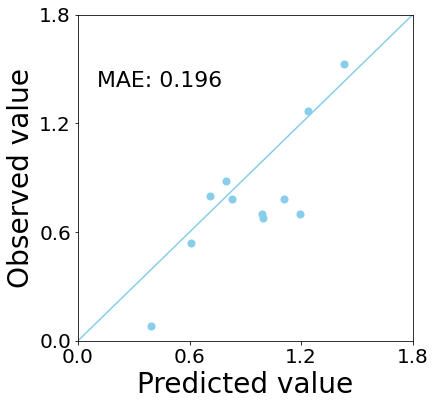

In [73]:
y=np.array([0.7965679, 0.3945303 ,0.9889494, 0.7106503, 1.1075947 , 0.9943569 ,1.2391137,
 1.1937499, 0.8279954 ,0.6080369 ,1.4321747])
x=np.array([0.88, 0.08, 0.7 , 0.8 , 0.78, 0.68, 1.27, 0.7 , 0.78, 0.54, 1.53])
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
from matplotlib.pyplot import MultipleLocator
fig = plt.figure(figsize=(6,6))
plt.plot([0,1.8],[0,1.8],c='skyblue')
plt.scatter(y,x,c='skyblue',s=50)
plt.xlim([0,1.8])
plt.ylim([0,1.8])
x_major_locator=MultipleLocator(0.6)
y_major_locator=MultipleLocator(0.6)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.ylabel("Observed value",fontsize=28)
plt.xlabel("Predicted value",fontsize=28)
plt.tick_params(labelsize=20)
#plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=22)
plt.text(0.1,1.4,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=22)
#plt.text(0.1,1.2,'R2: %.3f'%r2_score(x,y),fontsize=22)

In [24]:
y_test=np.array([0.88,0.08,0.7,0.8,0.78,0.68,1.27,0.7,0.78,0.54,1.53])
labels_ee= -(1 - np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))/(1 + np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))
labels_ddg=-8.314*206.70*np.log((1-labels_ee)/(1+labels_ee))/4184
labels_ddg_std=(labels_ddg-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))
y_test_std=(y_test-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))

In [5]:
-8.314*298.15*np.log((1-0.99)/(1+0.99))/4184

3.136028943988819

In [61]:
loss = 'mse'
batch_size = 32
shuffle = np.array(list(range(len(react_spms))))
np.random.seed(2021)#5 6 10  520  2021
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels_ddg_std[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels_ddg_std[val_index]

train_gen = Graph_DataLoader(spms_train,elec_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size,predict=True)

In [73]:
model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 60
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/blind.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 5s 139ms/step - loss: 0.0690 - val_loss: 0.0418
model saved to ./data2/run_data/blind.ckpt-1
19/19 [==============================] - 2s 106ms/step - loss: 0.0342 - val_loss: 0.0326
model saved to ./data2/run_data/blind.ckpt-2
19/19 [==============================] - 2s 105ms/step - loss: 0.0226 - val_loss: 0.0285
model saved to ./data2/run_data/blind.ckpt-3
19/19 [==============================] - 2s 110ms/step - loss: 0.0176 - val_loss: 0.0310
model saved to ./data2/run_data/blind.ckpt-4
19/19 [==============================] - 2s 110ms/step - loss: 0.0117 - val_loss: 0.0271
model saved to ./data2/run_data/blind.ckpt-5
19/19 [==============================] - 2s 110ms/step - loss: 0.0087 - val_loss: 0.0141
model saved to ./data2/run_data/blind.ckpt-6
19/19 [==============================] - 2s 109ms/step - loss: 0.0063 - val_loss: 0.0122
model saved to ./data2/run_data/blind.ckpt-7
19/19 [==============================] - 2s 109ms/step - loss:

In [71]:
y

array([0.88, 0.08, 0.7 , 0.8 , 0.78, 0.68, 1.27, 0.7 , 0.78, 0.54, 1.53])

34/34 [==============================] - 4s 70ms/step - loss: 0.0501
[1.0505211  0.499404   1.0328448  0.63714105 0.96877676 1.0778172
 1.0868318  1.1405993  0.70803654 0.5496212  1.6696143 ]


Text(0.1, 1.3, 'R2: 0.300')

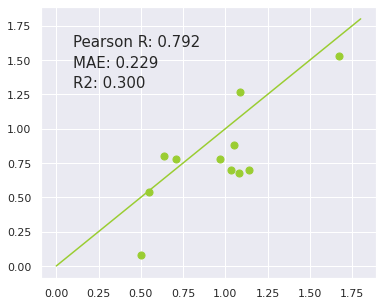

In [56]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=3,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-30') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

34/34 [==============================] - 5s 80ms/step - loss: 0.0505
[1.2066104  0.236462   1.1134701  0.46904457 0.97370905 0.9849749
 1.2071242  1.1734066  0.64766026 0.6368223  1.735919  ]


Text(0.1, 1.3, 'R2: 0.522')

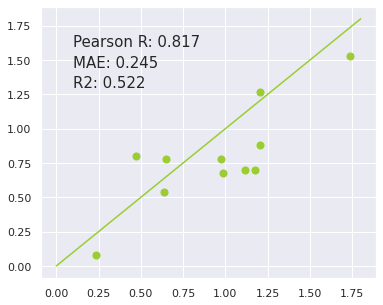

In [41]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-17') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

34/34 [==============================] - 4s 52ms/step - loss: 0.0534
[1.2129736  0.25473619 1.1187646  0.8170659  1.0657809  1.1024814
 0.77750283 0.9010243  0.9930511  0.591176   1.4158194 ]


Text(0.1, 1.3, 'R2: 0.089')

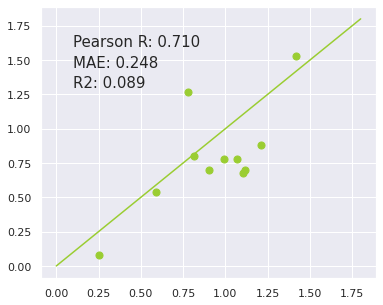

In [46]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=64,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-34') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

In [45]:
model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=512,interaction='True',final_act='none')
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 100
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/blind1.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 15s 698ms/step - loss: 0.0720 - val_loss: 0.0267
model saved to ./data2/run_data/blind1.ckpt-1
19/19 [==============================] - 13s 682ms/step - loss: 0.0243 - val_loss: 0.1629
model saved to ./data2/run_data/blind1.ckpt-2
19/19 [==============================] - 13s 672ms/step - loss: 0.0179 - val_loss: 0.0950
model saved to ./data2/run_data/blind1.ckpt-3
19/19 [==============================] - 13s 672ms/step - loss: 0.0137 - val_loss: 0.0112
model saved to ./data2/run_data/blind1.ckpt-4
19/19 [==============================] - 13s 673ms/step - loss: 0.0092 - val_loss: 0.0177
model saved to ./data2/run_data/blind1.ckpt-5
19/19 [==============================] - 13s 669ms/step - loss: 0.0067 - val_loss: 0.0185
model saved to ./data2/run_data/blind1.ckpt-6
19/19 [==============================] - 13s 671ms/step - loss: 0.0073 - val_loss: 0.0243
model saved to ./data2/run_data/blind1.ckpt-7
19/19 [==============================] - 13s 677

34/34 [==============================] - 20s 519ms/step - loss: 0.0511
[0.8113855  0.4254964  0.9934677  0.5980363  0.9943569  1.1207827
 1.1754543  1.1442522  0.8690264  0.61211175 1.4242499 ]


Text(0.1, 1.3, 'R2: 0.178')

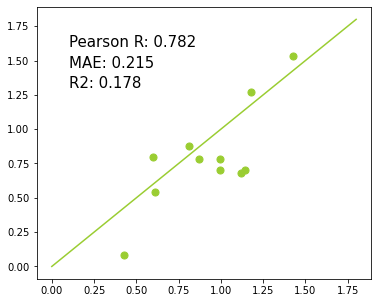

In [71]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=512,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind1.ckpt-69') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

34/34 [==============================] - 20s 525ms/step - loss: 0.0434
[0.7965679 0.3985303 0.9889494 0.7106503 1.1075947 1.1595323 1.2391137
 1.1937499 0.8279954 0.6080369 1.4321747]


Text(0.1, 1.3, 'R2: 0.170')

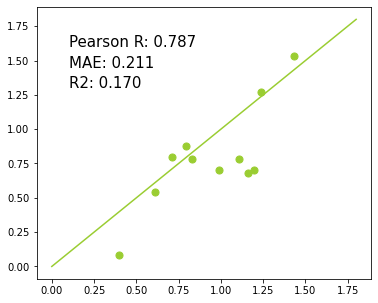

In [69]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=512,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind1.ckpt-42') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

In [45]:
x

array([0.7965679, 0.3985303, 0.9889494, 0.7106503, 1.1075947, 1.1595323,
       1.2391137, 1.1937499, 0.8279954, 0.6080369, 1.4321747],
      dtype=float32)

In [46]:
y

array([0.88, 0.08, 0.7 , 0.8 , 0.78, 0.68, 1.27, 0.7 , 0.78, 0.54, 1.53])

34/34 [==============================] - 20s 521ms/step - loss: 0.0457
[0.82211924 0.45651883 1.0200812  0.5772203  1.0413126  1.089609
 1.1655735  1.0874261  0.80358315 0.595081   1.3898269 ]


Text(0.1, 1.3, 'R2: 0.128')

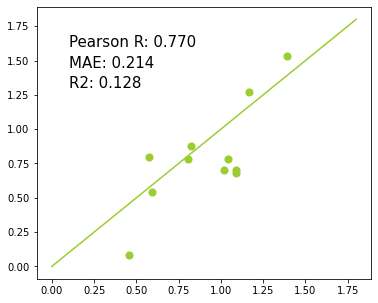

In [42]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=512,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind1.ckpt-93') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

In [53]:
test_cat_files[0]

'./data2/data2_sdf_files/test10_cat_0.sdf'

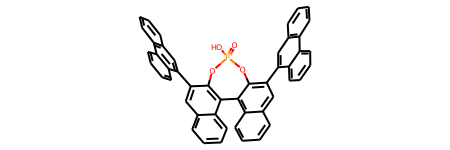

In [52]:
Chem.MolFromMolFile(test_cat_files[0])

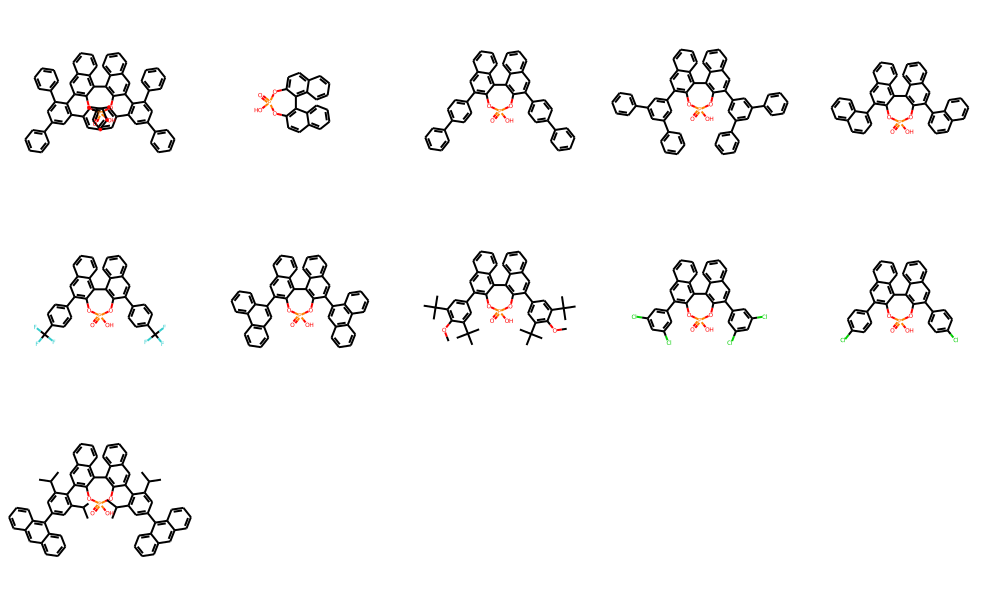

In [25]:
mol=[]
for i in test_cat_smiles:
    mol.append(Chem.MolFromSmiles(i)) 
from rdkit.Chem import Draw#[50:92]
img = Draw.MolsToGridImage(mol,molsPerRow=5,subImgSize=(200,200),legends=['' for x in mol])
img  
#ee=[0.86,0.07,0.53,0.59,0.58,0.52,0.79,0.53,0.58,0.43,0.63]
#y_test=np.array([0.88,0.08,0.7,0.8,0.78,0.68,1.27,0.7,0.78,0.54,1.53])

In [55]:
x

array([0.9542943 , 0.41480392, 1.0771219 , 0.6147052 , 1.05222   ,
       1.1358165 , 1.1327895 , 1.3433583 , 0.86231923, 0.69012445,
       1.39538   ], dtype=float32)

In [56]:
0.7965679, 0.3985303 ,0.9889494, 0.7106503, 1.1075947 , 0.9943569 ,1.2391137,
 1.1937499, 0.8279954 ,0.6080369 ,1.4321747

array([0.88, 0.08, 0.7 , 0.8 , 0.78, 0.68, 1.27, 0.7 , 0.78, 0.54, 1.53])

# picture

In [2]:
ee=[0.63,0.07,0.53,0.59,0.58,0.52,0.79,0.53,0.58,0.43,0.86]
ee=np.array(ee)
x=np.round(-8.314*298.15*np.log((1-ee)/(1+ee))/4184,3)
x

In [3]:
sorted([[a,e] for a,e in zip(x,y)],key=lambda x:x[0],reverse=True)

NameError: name 'y' is not defined

In [135]:
x

array([0.879, 0.083, 0.699, 0.803, 0.785, 0.683, 1.27 , 0.699, 0.785,
       0.545, 1.532])

Text(0.05, 1.65, 'R$^2$ = 0.585')

<Figure size 792x792 with 0 Axes>

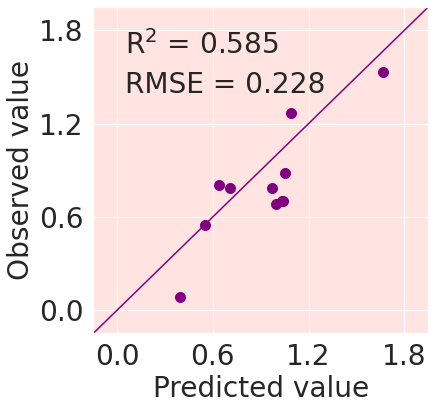

In [134]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
ee=[0.63,0.07,0.53,0.59,0.58,0.52,0.79,0.53,0.58,0.43,0.86]
ee=np.array(ee)
x=np.round(-8.314*298.15*np.log((1-ee)/(1+ee))/4184,3)
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
color='purple'#skyblue
start_point=-0.15
end_point=1.95
y=np.array([1.051, 0.395, 1.033, 0.637, 0.969, 0.993, 1.087, 1.041, 0.708,0.550 , 1.67 ])
#1.2066104  0.236462   1.1134701  0.46904457 0.97370905 0.9849749
 #1.2071242  1.1734066  0.64766026 0.6368223  1.735919 
#x=np.array([0.88, 0.08, 0.7 , 0.8 , 0.78, 0.68, 1.27, 0.7 , 0.78, 0.54, 1.53])
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,6))
ax=plt.gca()
ax.set_facecolor('mistyrose')
plt.plot([start_point,end_point],[start_point,end_point],c=color)
plt.scatter(y,x,c=color,s=100)
plt.xlim([start_point,end_point])
plt.ylim([start_point,end_point])
x_major_locator=MultipleLocator(0.6)
y_major_locator=MultipleLocator(0.6)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.ylabel("Observed value",fontsize=28)
plt.xlabel("Predicted value",fontsize=28)
plt.tick_params(labelsize=28)
#plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=22)
plt.text(0.05,1.4,'RMSE = %.3f'%(mean_squared_error(x,y))**(0.5),fontsize=28)
plt.text(0.05,1.65,'R$^2$ = %.3f'%r2_score(x,y),fontsize=28)

In [101]:
sorted(x, reverse=True)

[1.53, 1.27, 0.88, 0.8, 0.78, 0.78, 0.7, 0.7, 0.68, 0.54, 0.08]

In [103]:
x=np.array([1.53, 1.27, 0.88, 0.8, 0.78, 0.78, 0.7, 0.7, 0.68, 0.54, 0.08])
y=np.array([1.67,1.09,1.05,0.64,0.71,0.97,1.04,1.03,0.99,0.55,0.39])
y-x

array([ 0.14, -0.18,  0.17, -0.16, -0.07,  0.19,  0.34,  0.33,  0.31,
        0.01,  0.31])

Text(0.1, 1.4, 'MAE: 0.196')

<Figure size 792x792 with 0 Axes>

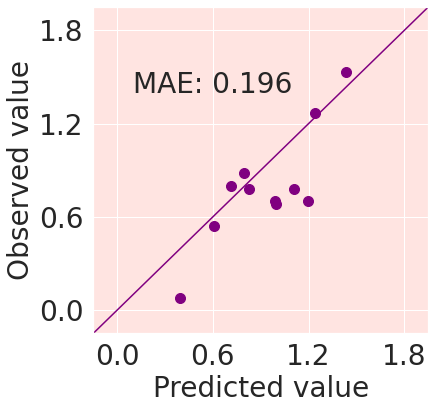

In [92]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
color='purple'#skyblue
start_point=-0.15
end_point=1.95
y=np.array([0.7965679, 0.3945303 ,0.9889494, 0.7106503, 1.1075947 , 0.9943569 ,1.2391137,
 1.1937499, 0.8279954 ,0.6080369 ,1.4321747])
x=np.array([0.88, 0.08, 0.7 , 0.8 , 0.78, 0.68, 1.27, 0.7 , 0.78, 0.54, 1.53])
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,6))
ax=plt.gca()
ax.set_facecolor('mistyrose')
plt.plot([start_point,end_point],[start_point,end_point],c=color)
plt.scatter(y,x,c=color,s=100)
plt.xlim([start_point,end_point])
plt.ylim([start_point,end_point])
x_major_locator=MultipleLocator(0.6)
y_major_locator=MultipleLocator(0.6)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.ylabel("Observed value",fontsize=28)
plt.xlabel("Predicted value",fontsize=28)
plt.tick_params(labelsize=28)
#plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=22)
plt.text(0.1,1.4,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=28)
#plt.text(0.1,1.2,'R2: %.3f'%r2_score(x,y),fontsize=22)

array([ 0.0834321, -0.3145303, -0.2889494,  0.0893497, -0.3275947,
       -0.3143569,  0.0308863, -0.4937499, -0.0479954, -0.0680369,
        0.0978253])

In [6]:
-8.314*298.15*np.log((1-0.95)/(1+0.95))/4184

2.1704843648311676

In [7]:
2.17*298.15/3.13

206.7046325878594

# new predict

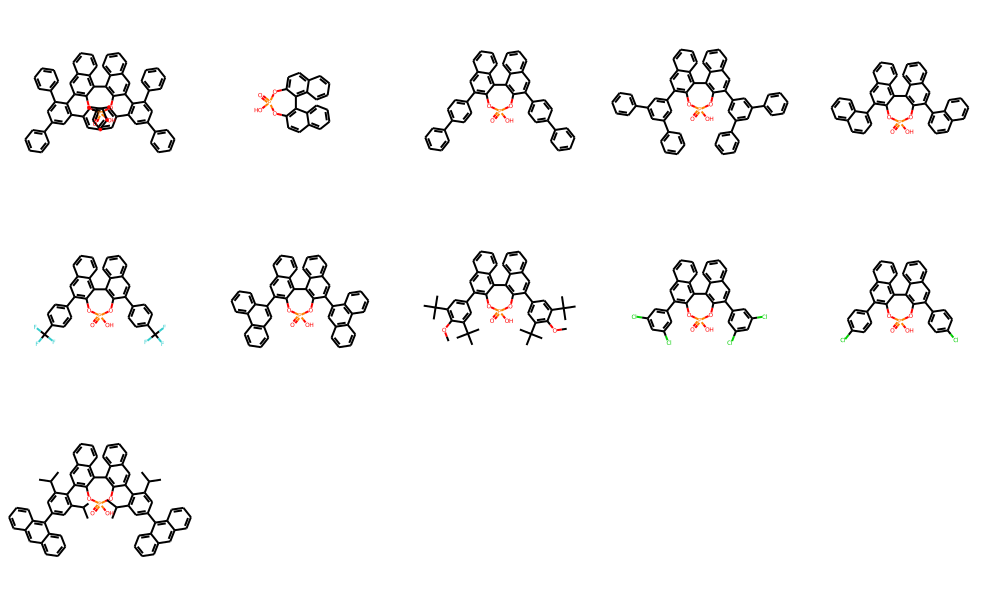

In [137]:
mol=[]
for i in test_cat_smiles:
    mol.append(Chem.MolFromSmiles(i)) 
from rdkit.Chem import Draw#[50:92]
img = Draw.MolsToGridImage(mol,molsPerRow=5,subImgSize=(200,200),legends=['' for x in mol])
img  

## train1

In [141]:
ee_test=np.array([0.61,0.07,0.51,0.57,0.65,0.5,0.68,0.52,0.55,0.41,0.75])
y_test=np.round(-8.314*298.15*np.log((1-ee_test)/(1+ee_test))/4184,3)
labels_ee= -(1 - np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))/(1 + np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))
labels_ddg=-8.314*298.15*np.log((1-labels_ee)/(1+labels_ee))/4184
labels_ddg_std=(labels_ddg-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))
y_test_std=(y_test-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))

loss = 'mse'
batch_size = 32
shuffle = np.array(list(range(len(react_spms))))
np.random.seed(2021)#5 6 10  520  2021
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels_ddg_std[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels_ddg_std[val_index]

train_gen = Graph_DataLoader(spms_train,elec_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size,predict=True)

In [142]:
model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 60
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/blind.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 5s 138ms/step - loss: 0.0722 - val_loss: 0.0418
model saved to ./data2/run_data/blind.ckpt-1
19/19 [==============================] - 2s 104ms/step - loss: 0.0333 - val_loss: 0.0316
model saved to ./data2/run_data/blind.ckpt-2
19/19 [==============================] - 2s 103ms/step - loss: 0.0202 - val_loss: 0.0316
model saved to ./data2/run_data/blind.ckpt-3
19/19 [==============================] - 2s 104ms/step - loss: 0.0152 - val_loss: 0.0270
model saved to ./data2/run_data/blind.ckpt-4
19/19 [==============================] - 2s 104ms/step - loss: 0.0099 - val_loss: 0.0235
model saved to ./data2/run_data/blind.ckpt-5
19/19 [==============================] - 2s 107ms/step - loss: 0.0074 - val_loss: 0.0190
model saved to ./data2/run_data/blind.ckpt-6
19/19 [==============================] - 2s 108ms/step - loss: 0.0061 - val_loss: 0.0177
model saved to ./data2/run_data/blind.ckpt-7
19/19 [==============================] - 2s 107ms/step - loss:

34/34 [==============================] - 5s 76ms/step - loss: 0.0504
[1.7062716  0.52089715 1.6450515  1.2279303  1.6009223  1.4588056
 1.4207177  0.97296536 1.2231528  0.88289833 2.0147295 ]


Text(0.1, 1.3, 'R2: -1.552')

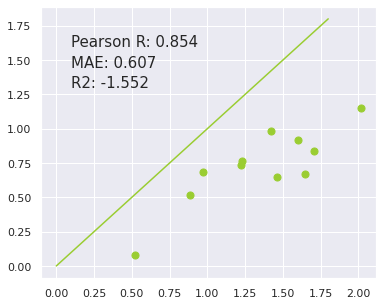

In [144]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-36') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

## train2

In [152]:
(2.12*298.15)/3.13

201.94185303514377

In [2]:
3.13*201.94

632.0722

In [3]:
2.12*298.15

632.078

In [158]:
(298.15*(97.29-2.71)/(97.29+2.71))/0.99

284.83865656565655

In [150]:
ee_test=np.array([(97.29-2.71)/(97.29+2.71)])
np.round(-8.314*298.15*np.log((1-ee_test)/(1+ee_test))/4184,3)

array([2.121])

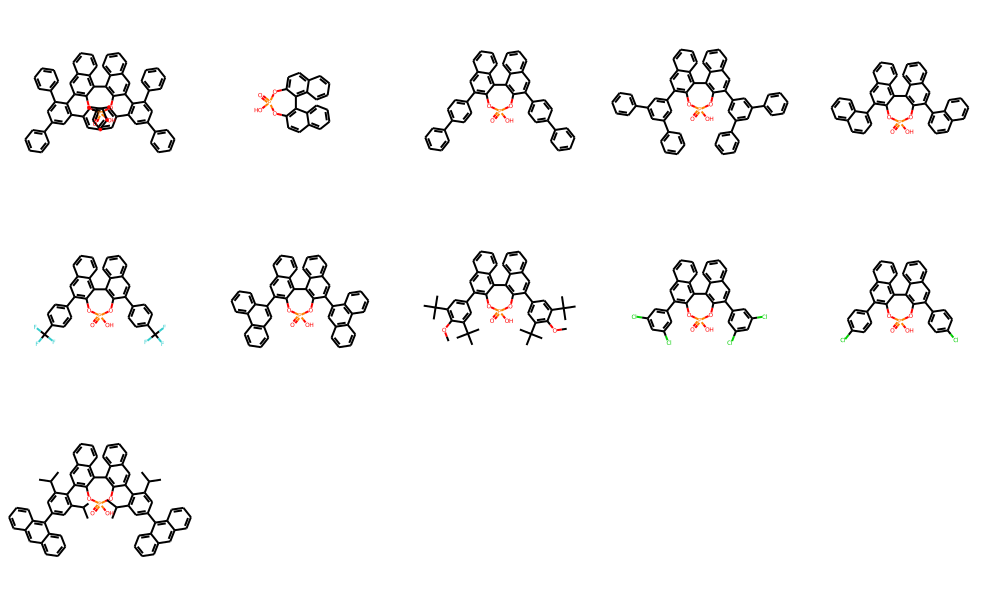

In [173]:
ee_test=np.array([0.61,0.07,0.51,0.57,0.65,0.5,0.68,0.52,0.55,0.41,0.75])
np.round(-8.314*298.15*np.log((1-ee_test)/(1+ee_test))/4184,3)

array([0.84 , 0.083, 0.667, 0.767, 0.919, 0.651, 0.982, 0.683, 0.733,
       0.516, 1.153])

In [163]:
ee_test=np.array([0.61,0.07,0.51,0.57,0.65,0.5,0.68,0.52,0.55,0.41,0.75])
y_test=np.round(-8.314*298.15*np.log((1-ee_test)/(1+ee_test))/4184,3)
labels_ee= -(1 - np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))/(1 + np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))
labels_ddg=-8.314*201.94*np.log((1-labels_ee)/(1+labels_ee))/4184
labels_ddg_std=(labels_ddg-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))
y_test_std=(y_test-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))

loss = 'mse'
batch_size = 32
shuffle = np.array(list(range(len(react_spms))))
np.random.seed(2021)#5 6 10  520  2021
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels_ddg_std[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels_ddg_std[val_index]

train_gen = Graph_DataLoader(spms_train,elec_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size,predict=True)

In [181]:
model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 50
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/blind.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 5s 143ms/step - loss: 0.0717 - val_loss: 0.0387
model saved to ./data2/run_data/blind.ckpt-1
19/19 [==============================] - 2s 107ms/step - loss: 0.0282 - val_loss: 0.0299
model saved to ./data2/run_data/blind.ckpt-2
19/19 [==============================] - 2s 109ms/step - loss: 0.0194 - val_loss: 0.0280
model saved to ./data2/run_data/blind.ckpt-3
19/19 [==============================] - 2s 109ms/step - loss: 0.0172 - val_loss: 0.0216
model saved to ./data2/run_data/blind.ckpt-4
19/19 [==============================] - 2s 112ms/step - loss: 0.0110 - val_loss: 0.0205
model saved to ./data2/run_data/blind.ckpt-5
19/19 [==============================] - 2s 110ms/step - loss: 0.0088 - val_loss: 0.0172
model saved to ./data2/run_data/blind.ckpt-6
19/19 [==============================] - 2s 114ms/step - loss: 0.0069 - val_loss: 0.0159
model saved to ./data2/run_data/blind.ckpt-7
19/19 [==============================] - 2s 113ms/step - loss:

34/34 [==============================] - 5s 79ms/step - loss: 0.0505
[0.8549572  0.18254101 0.52806365 0.4998515  0.8038378  0.9074136
 0.7455611  1.4047282  0.6621591  0.9567262  1.4717572 ]


Text(0.1, 1.3, 'R2: 0.255')

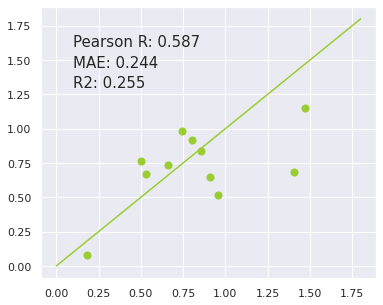

In [183]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-50') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

34/34 [==============================] - 5s 76ms/step - loss: 0.0480
[1.1374325  0.20304316 0.66564643 0.6517705  0.7711159  0.8106811
 0.52347755 0.81705844 0.62297773 0.50547636 1.0493964 ]


Text(0.1, 1.3, 'R2: 0.381')

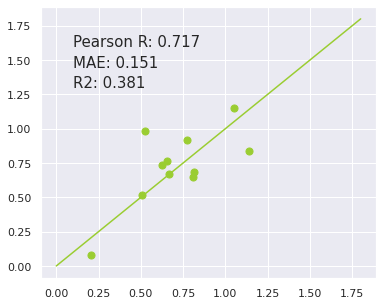

In [157]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-30') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

In [189]:
pred_value-exp_value

array([ 0.3  ,  0.117,  0.003, -0.117, -0.149,  0.159, -0.232,  0.137,
       -0.113, -0.006, -0.103])

In [188]:
pred_value=np.round([1.14, 0.2 , 0.67, 0.65, 0.77, 0.81, 0.75, 0.82, 0.62, 0.51, 1.05 ],2)
exp_value=np.array([0.84 , 0.083, 0.667, 0.767, 0.919, 0.651, 0.982, 0.683, 0.733,0.516, 1.153])

sorted([[i,j] for i,j in zip(pred_value,exp_value)],key=lambda x:x[1],reverse=True)

[[1.05, 1.153],
 [0.75, 0.982],
 [0.77, 0.919],
 [1.14, 0.84],
 [0.65, 0.767],
 [0.62, 0.733],
 [0.82, 0.683],
 [0.67, 0.667],
 [0.81, 0.651],
 [0.51, 0.516],
 [0.2, 0.083]]

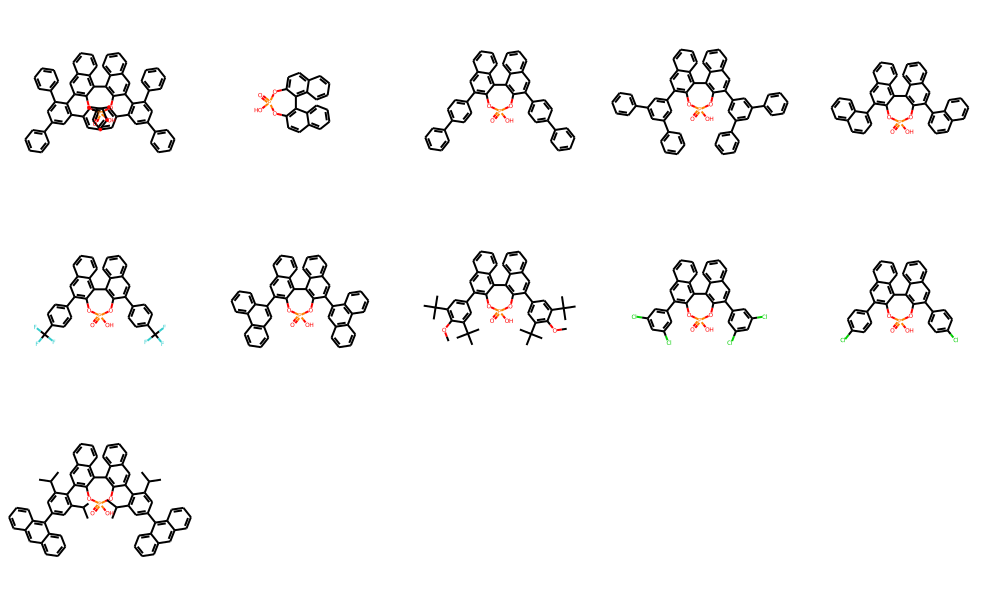

In [176]:
mol=[]
for i in test_cat_smiles:
    mol.append(Chem.MolFromSmiles(i)) 
from rdkit.Chem import Draw#[50:92]
img = Draw.MolsToGridImage(mol,molsPerRow=5,subImgSize=(200,200),legends=['' for x in mol])
img  

## train

In [170]:
ee_test=np.array([0.61,0.07,0.51,0.57,0.65,0.5,0.68,0.52,0.55,0.41,0.75])
y_test=np.round(-8.314*298.15*np.log((1-ee_test)/(1+ee_test))/4184,3)
labels_ee= -(1 - np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))/(1 + np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))
labels_ddg=-8.314*201.94*np.log((1-labels_ee)/(1+labels_ee))/4184
labels_ddg_std=(labels_ddg-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))
y_test_std=(y_test-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))

loss = 'mse'
batch_size = 32
shuffle = np.array(list(range(len(react_spms))))
np.random.seed(2021)#5 6 10  520  2021
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels_ddg_std[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels_ddg_std[val_index]

train_gen = Graph_DataLoader(spms_train,elec_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size,predict=True)

In [172]:
model = IGNN_model2(184, 33, 19,linear_depth=6,atom_attention=1,inter_attention=1,end_attention=1,hidden_size=128)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 60
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/blind.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 6s 162ms/step - loss: 0.0333 - val_loss: 0.0337
model saved to ./data2/run_data/blind.ckpt-1
19/19 [==============================] - 2s 120ms/step - loss: 0.0167 - val_loss: 0.0289
model saved to ./data2/run_data/blind.ckpt-2
19/19 [==============================] - 2s 124ms/step - loss: 0.0104 - val_loss: 0.0269
model saved to ./data2/run_data/blind.ckpt-3
19/19 [==============================] - 2s 125ms/step - loss: 0.0094 - val_loss: 0.0246
model saved to ./data2/run_data/blind.ckpt-4
19/19 [==============================] - 2s 124ms/step - loss: 0.0074 - val_loss: 0.0276
model saved to ./data2/run_data/blind.ckpt-5
19/19 [==============================] - 2s 125ms/step - loss: 0.0069 - val_loss: 0.0226
model saved to ./data2/run_data/blind.ckpt-6
19/19 [==============================] - 2s 128ms/step - loss: 0.0063 - val_loss: 0.0221
model saved to ./data2/run_data/blind.ckpt-7
19/19 [==============================] - 2s 131ms/step - loss:

34/34 [==============================] - 5s 90ms/step - loss: 0.0252
[0.61675906 0.2887474  1.5712029  0.96460223 0.94210374 1.0090802
 1.2600602  0.89298594 0.45495746 1.0571855  1.6314548 ]


Text(0.1, 1.3, 'R2: -0.026')

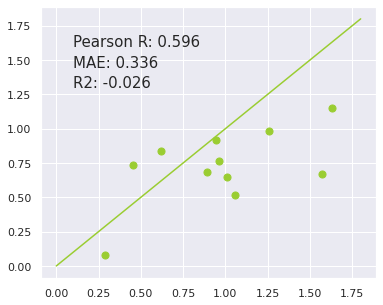

In [174]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=6,atom_attention=1,inter_attention=1,end_attention=1,hidden_size=128)
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-40') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

## train3

In [160]:
ee_test=np.array([0.61,0.07,0.51,0.57,0.65,0.5,0.68,0.52,0.55,0.41,0.75])
y_test=np.round(-8.314*298.15*np.log((1-ee_test)/(1+ee_test))/4184,3)
labels_ee= -(1 - np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))/(1 + np.exp(labels * 4.18 * 1000/8.314/(25+273.15)))
labels_ddg=-8.314*284.84*np.log((1-labels_ee)/(1+labels_ee))/4184
labels_ddg_std=(labels_ddg-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))
y_test_std=(y_test-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))

loss = 'mse'
batch_size = 32
shuffle = np.array(list(range(len(react_spms))))
np.random.seed(2021)#5 6 10  520  2021
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],labels_ddg_std[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],labels_ddg_std[val_index]

train_gen = Graph_DataLoader(spms_train,elec_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size,predict=True)

In [161]:
model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 60
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/blind.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 5s 138ms/step - loss: 0.0689 - val_loss: 0.0374
model saved to ./data2/run_data/blind.ckpt-1
19/19 [==============================] - 2s 103ms/step - loss: 0.0281 - val_loss: 0.0275
model saved to ./data2/run_data/blind.ckpt-2
19/19 [==============================] - 2s 103ms/step - loss: 0.0213 - val_loss: 0.0294
model saved to ./data2/run_data/blind.ckpt-3
19/19 [==============================] - 2s 103ms/step - loss: 0.0138 - val_loss: 0.0190
model saved to ./data2/run_data/blind.ckpt-4
19/19 [==============================] - 2s 104ms/step - loss: 0.0103 - val_loss: 0.0179
model saved to ./data2/run_data/blind.ckpt-5
19/19 [==============================] - 2s 106ms/step - loss: 0.0087 - val_loss: 0.0334
model saved to ./data2/run_data/blind.ckpt-6
19/19 [==============================] - 2s 107ms/step - loss: 0.0072 - val_loss: 0.0164
model saved to ./data2/run_data/blind.ckpt-7
19/19 [==============================] - 2s 106ms/step - loss:

34/34 [==============================] - 5s 76ms/step - loss: 0.0471
[1.3013438  0.34070888 1.7729466  1.5437636  1.0009495  1.2898917
 1.7118626  1.4411664  1.0645512  1.2399839  2.8675604 ]


Text(0.1, 1.3, 'R2: -0.870')

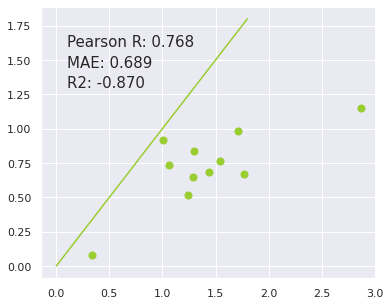

In [162]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-17') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)

In [ ]:
#

In [145]:
model = IGNN_model2(184, 33, 19,linear_depth=7,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=loss)
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 60
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data2/run_data/blind.ckpt')
    print("model saved to %s" % path)#6 1 128

19/19 [==============================] - 6s 177ms/step - loss: 0.0699 - val_loss: 0.0413
model saved to ./data2/run_data/blind.ckpt-1
19/19 [==============================] - 3s 134ms/step - loss: 0.0324 - val_loss: 0.0310
model saved to ./data2/run_data/blind.ckpt-2
19/19 [==============================] - 3s 134ms/step - loss: 0.0248 - val_loss: 0.0200
model saved to ./data2/run_data/blind.ckpt-3
19/19 [==============================] - 3s 140ms/step - loss: 0.0151 - val_loss: 0.0196
model saved to ./data2/run_data/blind.ckpt-4
19/19 [==============================] - 3s 140ms/step - loss: 0.0112 - val_loss: 0.0303
model saved to ./data2/run_data/blind.ckpt-5
19/19 [==============================] - 3s 141ms/step - loss: 0.0087 - val_loss: 0.0118
model saved to ./data2/run_data/blind.ckpt-6
19/19 [==============================] - 3s 140ms/step - loss: 0.0082 - val_loss: 0.0076
model saved to ./data2/run_data/blind.ckpt-7
19/19 [==============================] - 3s 139ms/step - loss:

34/34 [==============================] - 6s 101ms/step - loss: 0.0488
[1.268869   0.38800898 1.1940708  0.91809034 1.1561755  1.5226737
 1.0985001  1.2118031  0.7477666  1.0971756  2.1339881 ]


Text(0.1, 1.3, 'R2: -0.549')

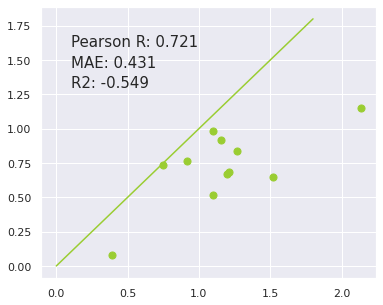

In [146]:
test_gen_predict = Graph_DataLoader(all_blind_react_spms,all_blind_react_elec,y_test_std,batch_size=batch_size,predict=True)
all_gen = Graph_DataLoader(react_spms,react_elec,label_std,batch_size=batch_size)
opt = tf.keras.optimizers.Adam()
new_model = IGNN_model2(184, 33, 19,linear_depth=7,atom_attention=1,inter_attention=1,
                    end_attention=1,hidden_size=128,interaction='True',final_act='none')
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(all_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
#checkpoint.restore(tf.train.latest_checkpoint('./Dataset/new_model_run_data/')) 
checkpoint.restore('./data2/run_data/blind.ckpt-58') # 0.0035  
y_pred = new_model.predict(test_gen_predict)
y_pred=y_pred*(labels_ddg.max()-labels_ddg.min())+labels_ddg.min()

x=y_pred.reshape(-1)
y=y_test.reshape(-1)
#x=x-0.25
print(x)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
fig = plt.figure(figsize=(6,5))
plt.plot([0,1.8],[0,1.8],c='yellowgreen')

#plt.xticks([0,0.6,1.2,1.8])
#plt.yticks([0,0.6,1.2,1.8])
plt.scatter(x,y,c='yellowgreen',s=50)
plt.text(0.1,1.6,'Pearson R: %.3f'%pearsonr(x,y)[0],fontsize=15)
plt.text(0.1,1.45,'MAE: %.3f'%mean_absolute_error(x,y),fontsize=15)
plt.text(0.1,1.3,'R2: %.3f'%r2_score(x,y),fontsize=15)